Preparing data for analysis

In [17]:
# uncomment + run if they aren't installed already
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_gpu_energies = []
d_gpu_energies = []

y_cpu_energies = []
d_cpu_energies = []

# iterate over 30 runs per model
for i in range(30):
    df_yolo = pd.read_csv(f'../experiment/results/yolo_run{i+1}.csv')
    df_detr = pd.read_csv(f'../experiment/results/rfdetr_run{i+1}.csv')

    # convert power to Watts
    y_gpu_power = df_yolo['GPU0_POWER (mWatts)'] / 1000
    d_gpu_power = df_detr['GPU0_POWER (mWatts)'] / 1000
    
    # make time start from zero
    y_time = df_yolo['Time'] - df_yolo['Time'].iloc[0]
    d_time = df_detr['Time'] - df_detr['Time'].iloc[0]
    
    # compute total energy of this run
    # time is converted to seconds
    y_gpu_energy = np.trapezoid(y_gpu_power, y_time / 1000)
    d_gpu_energy = np.trapezoid(d_gpu_power, d_time / 1000)
    
    # append energy per model inference execution
    # 1500 images assumed per run 
    y_gpu_energies.append(y_gpu_energy / 1500)
    d_gpu_energies.append(d_gpu_energy / 1500)
    
    # monotonic counter -> need to compute difference between start and end for total energy
    y_cpu_energy = df_yolo['PP0_ENERGY (J)'].iloc[-1] - df_yolo['PP0_ENERGY (J)'].iloc[0]
    d_cpu_energy = df_detr['PP0_ENERGY (J)'].iloc[-1] - df_detr['PP0_ENERGY (J)'].iloc[0]
    
    y_cpu_energies.append(y_cpu_energy / 1500)
    d_cpu_energies.append(d_cpu_energy / 1500)
    
print(f'YOLO average GPU energy per inference: {y_gpu_energies}')
print(f'\nRF_DETR average GPU energy per inference: {d_gpu_energies}')

print(f'\nYOLO average CPU energy per inference: {y_cpu_energies}')
print(f'\nRF-DETR average CPU energy per inference: {d_cpu_energies}')

YOLO average GPU energy per inference: [np.float64(1.2435650483333331), np.float64(1.2439616316666664), np.float64(1.2381677296666667), np.float64(1.2416877606666668), np.float64(1.2456194506666667), np.float64(1.241557352), np.float64(1.2447878413333335), np.float64(1.2415570656666668), np.float64(1.2500659876666664), np.float64(1.2464784313333335), np.float64(1.2438062073333331), np.float64(1.2438065329999999), np.float64(1.2393465576666667), np.float64(1.2504483923333332), np.float64(1.2509980273333334), np.float64(1.2509627933333334), np.float64(1.24206677), np.float64(1.245082615), np.float64(1.2411762336666667), np.float64(1.243649666), np.float64(1.2479178663333335), np.float64(1.2441703603333334), np.float64(1.2464954936666666), np.float64(1.251596494), np.float64(1.2446007683333333), np.float64(1.2490727830000001), np.float64(1.2433908336666666), np.float64(1.2441154213333332), np.float64(1.2426606296666667), np.float64(1.246350977)]

RF_DETR average GPU energy per inference: 

Violin and Box plots

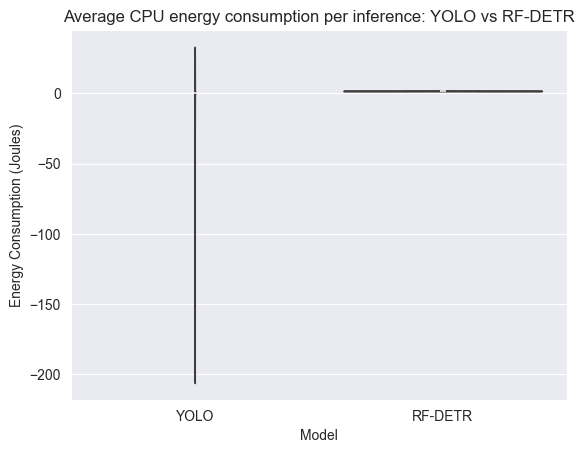

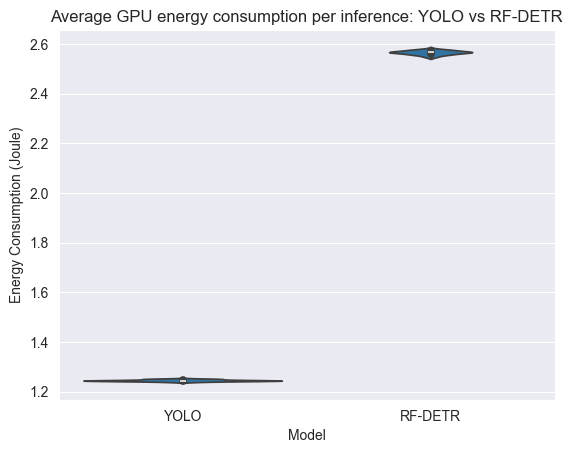

In [21]:
def plot_violin_and_box(yolo, detr, y_axis, y_label, title):

    data = pd.DataFrame({
        y_axis: np.concatenate([yolo, detr]),
        'Model': ['YOLO']*len(yolo) + ['DETR']*len(detr)
    })
    
    # Violin + Box plots
    sns.violinplot(data=data, x='Model', y=y_axis, inner='box')
    plt.xticks(ticks=[0, 1], labels=labels)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()
    
labels = ['YOLO', 'RF-DETR']

plot_violin_and_box(y_cpu_energies, d_cpu_energies, 'Energy', 'Energy Consumption (Joules)', 'Average CPU energy consumption per inference: YOLO vs RF-DETR')

# plot_violin_and_box(y_gpu_power, d_gpu_power, 'Power', 'Power Consumption (Watts)', 'GPU Power Consumption: YOLO vs RF-DETR')

plot_violin_and_box(y_gpu_energies, d_gpu_energies, 'Energy', 'Energy Consumption (Joule)', 'Average GPU energy consumption per inference: YOLO vs RF-DETR')

Statistical tests

In [25]:
# !pip install scipy

from scipy.stats import ttest_ind, shapiro, mannwhitneyu


# if data is not normal (see the violin plots), then we need other tests / procedures

def statistical_tests(y, d):
    # Shapiro-Wilk test (testing normality)
    shap_yolo = shapiro(y)
    shap_detr = shapiro(d)

    # Statistical significance tests depending on normality
    if shap_yolo.pvalue < 0.05 or shap_detr.pvalue < 0.05:
        print("Some dataset is NOT normally distributed.")

        # Statistical significance test
        print('Statistical significance test')

        # null hypothesis: distribution of yolo is the same as rf-detr
        # if p_values < 0.05, then we can assume different distributions
        mwu = mannwhitneyu(y, d)
        print(f'\tMann-Whitney U test: '
              f'\n\t\t{mwu.statistic} '
              f'\n\t\t{mwu.pvalue}')

        print('Effect size analysis')

        median_yolo = np.median(y)
        median_detr = np.median(d)
        median_difference = median_yolo - median_detr

        cles = mwu.statistic / (len(y) * len(d))

        print(f'\tMedian difference: {median_difference:.2f}')
        print(f'\tCommon language effect size: {cles:.2f}')

    else:
        print("Normal distribution can be assumed.")

        # Statistical significance test (Welch's t-test)
        _, welch_pvalue = ttest_ind(
            y, d, equal_var=False, alternative='two-sided')

        print('\nStatistical significance test')
        if welch_pvalue < 0.05:
            print(f'\tP-value is significant ({welch_pvalue})')
        else:
            print(f'\tP-value is not significant ({welch_pvalue})')

        print('\nEffect size analysis')

        # using "raw" difference to retain more information
        mean_diff = d.mean() - y.mean()
        percentage_change = (mean_diff / y.mean()) * 100
        cohen_d = mean_diff / (0.5 * np.sqrt(y.std()**2 + d.std()**2))

        print(f'\tMean difference: {mean_diff:.2f}')
        print(f'\tPercentage change: {percentage_change:.2f}')
        print(f'\tCohen\'s Difference: {cohen_d:.2f}')


print('GPU energy consumption')
statistical_tests(np.array(y_gpu_energies), np.array(d_gpu_energies))
print('-------')
print('CPU energy consumption')
statistical_tests(np.array(y_cpu_energies), np.array(d_cpu_energies))

GPU energy consumption
Normal distribution can be assumed.

Statistical significance test
	P-value is significant (1.2800565331276762e-85)

Effect size analysis
	Mean difference: 1.32
	Percentage change: 106.06
	Cohen's Difference: 306.62
-------
CPU energy consumption
Some dataset is NOT normally distributed.
Statistical significance test
	Mann-Whitney U test: 
		0.0 
		3.019859359162157e-11
Effect size analysis
	Median difference: -1.17
	Common language effect size: 0.00


PRELIMINARY insights for GPU:
- On average per image inference, RF-DETR uses 106% (2.06 times) more energy than YOLO.
- The p-value of Cohen's d is extremely high. This could be due to the variance being near zero. That can cause a high value. The hardware is apparently very consistent in its execution between runs.
- The Welch's T-test p-value is 10^-85, which means we can reject the null hypothesis that both models have the same mean GPU energy consumption. The measurements are not due to chance.

Graph plots

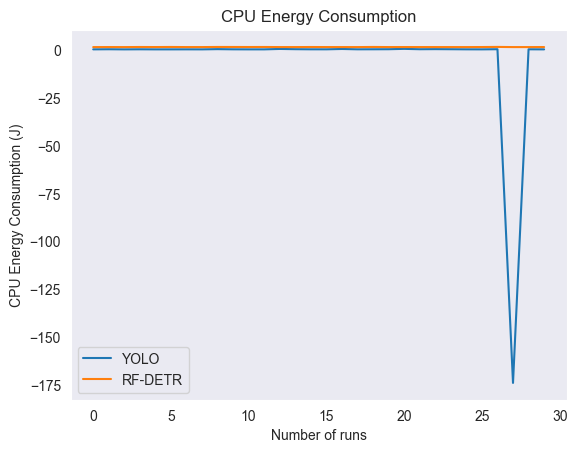

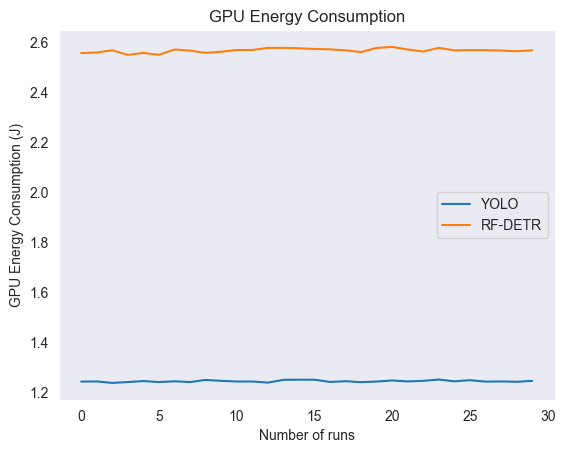

In [26]:
# Nvidia GPU label: GPU0_POWER (mWatts)

# CPU

plt.plot(range(30), y_cpu_energies, label='YOLO')
plt.plot(range(30), d_cpu_energies, label='RF-DETR')

plt.xlabel('Number of runs')
plt.ylabel('CPU Energy Consumption (J)')
plt.title('CPU Energy Consumption')
plt.legend()
plt.grid()
plt.show()

# GPU

plt.plot(range(30), y_gpu_energies, label='YOLO')
plt.plot(range(30), d_gpu_energies, label='RF-DETR')

plt.xlabel('Number of runs')
plt.ylabel('GPU Energy Consumption (J)')
plt.title('GPU Energy Consumption')
plt.legend()
plt.grid()
plt.show()